### Check the policy evaluation DQN training

do training on uniform dataset

do policy evaluation on the actual mdp

check if they are similar


In [38]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
import os
import sys
import time
import random
import pandas as pd
import yaml
from liftoff import parse_opts
from argparse import Namespace
from experiment_src import *
import numpy as np

root_dir = os.path.dirname(os.path.dirname(os.path.dirname(os.path.realpath("."))))
sys.path.append(root_dir)

# from experiment_src import run_sampling_regret_experiment, generate_random_policy_transitions
from experiments.experiment_utils import setup_logger, seed_everything
from overfitting.src.policy_iteration import random_policy_evaluation_q_stochastic
from overfitting.src.utils import create_random_policy, extract_V_from_Q_for_stochastic_policy

import logging

In [40]:
# Env settings 
start_state = (0, 0)
terminal_states = {(3, 3): 1.0}
rows, cols = 4, 4
p_success = 1
seed = 3

num_steps = 40_000
lower_bound_softmax = 1.25 / 80
# lower_bound_softmax = 0

# Learning hyperparameters
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.05  # Convergence criterion
tau = 100
batch_size = 32
train_max_iterations = 50
theta = 1e-6

np.random.seed(seed)
    
logger = logging.getLogger(__name__)

env = make_env(rows, cols, start_state, p_success, terminal_states, seed)

states = list(set([s for s, _ in env.mdp.keys()]))
actions = list(set([a for _, a in env.mdp.keys()]))

random_policy = create_random_policy(states, actions)

Q = {state: {action: 0 for action in actions} for state in states}
Q = random_policy_evaluation_q_stochastic(states, actions, random_policy, Q, env.mdp, gamma=gamma, theta=theta)

# Extract the state-value function V from the Q-function
V_random_policy = extract_V_from_Q_for_stochastic_policy(Q, random_policy, states)
print(V_random_policy)

# keys = list(env.mdp.keys())
# len(keys)

{(0, 1): 0.08679027986596795, (1, 2): 0.1666409273261716, (2, 1): 0.1666412378901533, (0, 0): 0.07101006142668265, (3, 1): 0.22556174899214265, (1, 1): 0.11404420509292103, (0, 3): 0.1388665162819428, (2, 0): 0.11389333520382322, (3, 0): 0.13886786700937978, (2, 3): 0.4714262688081644, (0, 2): 0.11389269295309992, (2, 2): 0.28713034614939903, (1, 0): 0.08679120349690139, (3, 2): 0.4714266909165472, (1, 3): 0.22556129509284042}


In [41]:
transitions_list = [(key[0], key[1], *value[0]) for key, value in env.mdp.items()]
# transitions_train, transitions_val = train_test_split(
#     transitions_list, test_size=0.2, random_state=seed
# )

# random_policy_transitions = generate_random_policy_transitions(transitions_list, 
#                                                                num_steps, 
#                                                                env, 
#                                                                actions, 
#                                                                seed, 
#                                                                logger)


random_policy_transitions = generate_transitions_observations(
        transitions_list,
        num_steps,
        tau=tau,
        lower_bound=lower_bound_softmax / len(transitions_list),
    )
# random_policy_transitions

### Training
input_size = len(states[0])  # Or another way to represent the size of your input
output_size = len(actions)

# Initialize the DQN
dqn_random_policy = DQN(input_size, output_size)

loss_record_random_policy = train_net_with_sarsa(
        dqn_random_policy,
        random_policy_transitions,
        states,
        actions,
        gamma,
        epsilon,
        batch_size,
        train_max_iterations,
        logger,
    )
    


Text(0.5, 1.0, 'Train State Counts')

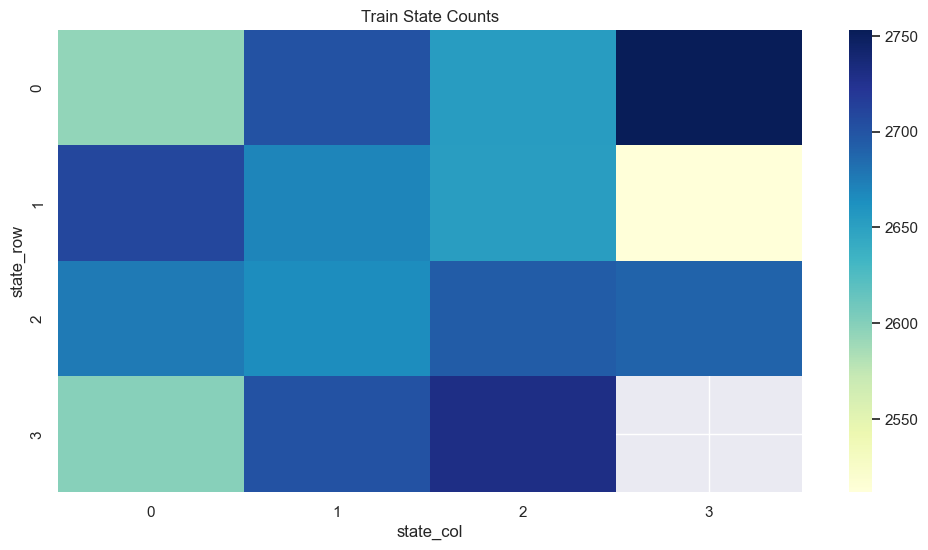

In [42]:
# Convert dataset to DataFrame
columns = ['state', 'action', 'next_state', 'reward', 'done', 'prob']

df = pd.DataFrame(random_policy_transitions, columns=columns)
df[['state_row', 'state_col']] = pd.DataFrame(df['state'].tolist(), index=df.index)
df[['next_state_row', 'next_state_col']] = pd.DataFrame(df['next_state'].tolist(), index=df.index)


###### Figure for state counts heatmaps
train_state_counts = df.groupby(['state_row', 'state_col']).size().reset_index(name='counts')
train_state_heatmap = train_state_counts.pivot(index='state_row', columns='state_col', values='counts')


plt.figure(figsize=(12, 6))

# Plot Train State Counts Heatmap
# plt.subplot(1, 2, 1)
sns.heatmap(train_state_heatmap, annot=False, cmap="YlGnBu")
plt.title('Train State Counts')

In [43]:
def estimate_V_from_DQN(dqn, env, states, num_simulations, max_steps_per_simulation=100):
    V_estimated = {state: 0 for state in states}
    for i, state in enumerate(states):
        if i % 20 == 0:
            print(f"Simulation {i} of {len(states)} for state {state}")
        total_reward = 0
        for _ in range(num_simulations):
            # Reinstantiate the environment for each simulation to reset its state
            env = make_env(rows, cols, state, p_success, terminal_states, seed=None)
            steps = 0  # Keep track of the number of steps
            done = False
            while not done and steps < max_steps_per_simulation:
                state_tensor = torch.tensor([state], dtype=torch.float)
                action_values = dqn(state_tensor)
                action = torch.argmax(action_values).item()
                next_state, reward, done, _, _ = env.step(action)
                total_reward += (gamma ** steps) * reward
                steps += 1  # Increment step count
                if done:
                    break
        V_estimated[state] = total_reward / num_simulations
    return V_estimated

def compare_value_functions(V1, V2, states):
    mse = sum((V1[state] - V2[state])**2 for state in states) / len(states)
    return mse

V_estimated = estimate_V_from_DQN(dqn_random_policy, env, states, num_simulations=100, max_steps_per_simulation=1000)

# Assuming V_estimated is obtained from estimate_V_from_DQN
mse = compare_value_functions(V_random_policy, V_estimated, states)
print(f"Mean Squared Error between V_random_policy and V_estimated: {mse}")

Simulation 0 of 15 for state (0, 1)
Mean Squared Error between V_random_policy and V_estimated: 0.17109281969474857


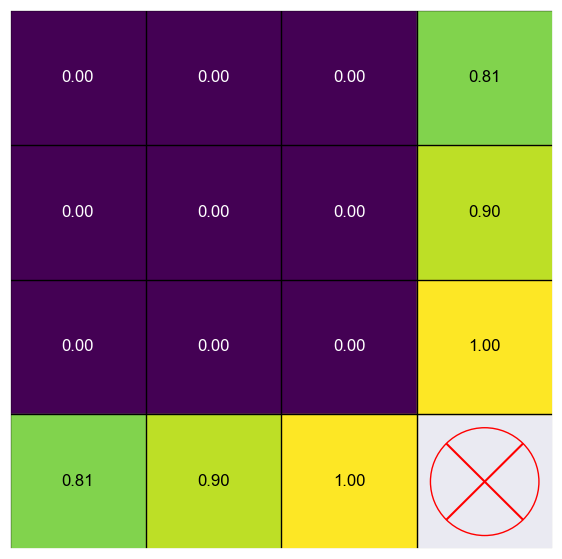

In [46]:
draw_simple_gridworld(
    (rows, cols),
    [],
    V_estimated,
    env.terminal_states,
    policy=None,
    enable_heatmap=True,
)

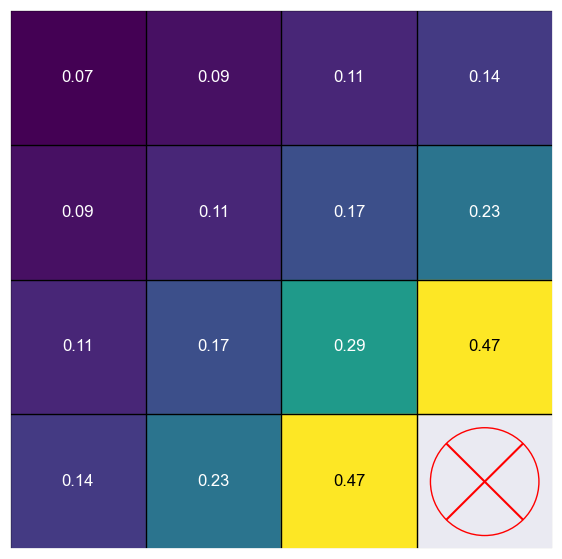

In [44]:
from overfitting.src.visualize import draw_simple_gridworld

draw_simple_gridworld(
    (rows, cols),
    [],
    V_random_policy,
    env.terminal_states,
    policy=None,
    enable_heatmap=True,
)